## **Bank churn prediction** 

Aims: Build a prediction model that will perform the following: Classify if a customer is going to churn or not
Preferably and based on model performance, choose a model that will attach a probability to the churn to make it easier for customer service to target low hanging fruits in their efforts to prevent churn

In [2]:
# Importing project dependencies 

# Data handling
import pandas as pd
import numpy as np

# Data warehousing 
from sqlalchemy import create_engine
import pyodbc
import urllib

# Exploratory Data Analysis & Visualisation 
%matplotlib inline
import pandas_profiling
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# Feature Engineering and Modelling 
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier

# Model imporvement and Evaluation 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn import metrics
import math

# Model export for deployment 
import pickle

# Supressing warning messages 
from warnings import filterwarnings
filterwarnings("ignore")  

#### **----------------------------------  1. Data collection  -----------------------------------**

In [3]:
# Importing data through API 
# !kaggle datasets download -d kmalit/bank-customer-churn-prediction -p ..\Data --unzip 

In [4]:
# Reading data into dataframe 
data = pd.read_csv('../Data/Churn_Modelling.csv')

#### **----------------------------------  2. Data pre-processing  -----------------------------------**

In [5]:
# Viewing first 5 rows of data
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
# Viewing the data types of the columns
data.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [7]:
# Viewing dataset shape
data.shape

(10000, 14)

In [8]:
# 1st check for null values and datatype check 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [9]:
# 2nd check for number of null values
data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [10]:
# Unique count for each variable
data.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [11]:
# Viewing summary of statistics for numeric columns
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [12]:
# (SQL standard) Formatting column headers by removing potential capital letters and spaces in column headers 
data.columns = data.columns.str.lower()
data.columns = data.columns.str.replace(' ','_')

#### **----------------------------------  3. Data Warehousing  -----------------------------------**

In [13]:
# Saving cleaned data as csv
data.to_csv('../Data/bankchurn_clean.csv', index=False)

In [14]:
def ETL_SQLServer(Server,db,tablename):
  """
    :param Server: Destination Server
    :param db: Destination Database name MUST ALREADY EXIST
    :param tablename: Project ID and Dataset name
    """

  # SQL table header format
  tablename = tablename.lower()
  tablename = tablename.replace(' ','_')

  quoted = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=%s;DATABASE=%s"%(Server,db))
  engine = create_engine('mssql+pyodbc:///?odbc_connect={}'.format(quoted))

  data.to_sql('{tb}'.format(tb=tablename), schema='dbo', con = engine, index=False, if_exists='replace')

  return("ETL successful, {num} rows loaded into table: {tb}.".format(num=len(data.iloc[:,0]), tb=tablename))

In [15]:
# # Function to warehouse dataframe
ETL_SQLServer("DESKTOP-I9HIN85","Projects","P2 bank churn")
# [SERVER NAME]

'ETL successful, 10000 rows loaded into table: p2_bank_churn.'

#### **----------------------------------  4. Exploratory data analysis  -----------------------------------**

In [16]:
# Checking distribution of categorical fields 
print(data.geography.value_counts())
print(data.gender.value_counts())
print(data.exited.value_counts())

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64
Male      5457
Female    4543
Name: gender, dtype: int64
0    7963
1    2037
Name: exited, dtype: int64


In [17]:
# Viewing summary of statistics for numeric columns
data.describe()

,rownumber,customerid,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [18]:
# Setting my custom color palette
colors = ["#32CD32","#FF0000"]
sns.set_palette(sns.color_palette(colors))

In [19]:
totretained = data[data['exited'] == 0]['exited'].count() / data.shape[0] * 100
totlost = data[data['exited'] == 1]['exited'].count() / data.shape[0] * 100

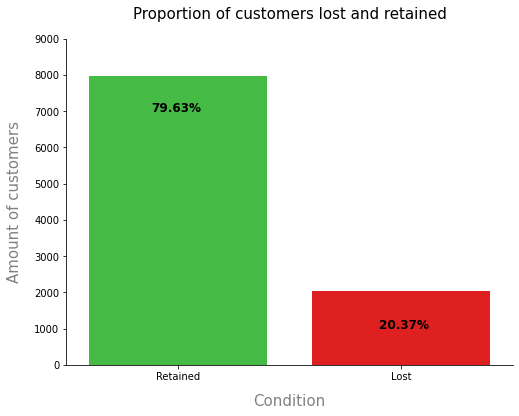

In [20]:
# Showing distribtuon of target values 
fig, ax = plt.subplots()
plt.figure(figsize=(8,6),facecolor='white')
sns.countplot(x='exited', data=data)
plt.xticks([0, 1], ['Retained', 'Lost'])
plt.xlabel('Condition', size=15, labelpad=12, color='grey')
plt.ylabel('Amount of customers', size=15, labelpad=12, color='grey')
plt.title("Proportion of customers lost and retained", size=15, pad=20)
plt.ylim(0, 9000)
plt.text(-0.12, 7000, f"{round(totretained, 2)}%", fontsize=12,weight='bold')
plt.text(0.90, 1000, f"{round(totlost, 2)}%", fontsize=12,weight='bold')
sns.despine()
plt.savefig('../images/Churn_barchart_distrib.png')
plt.close(1)
plt.show()

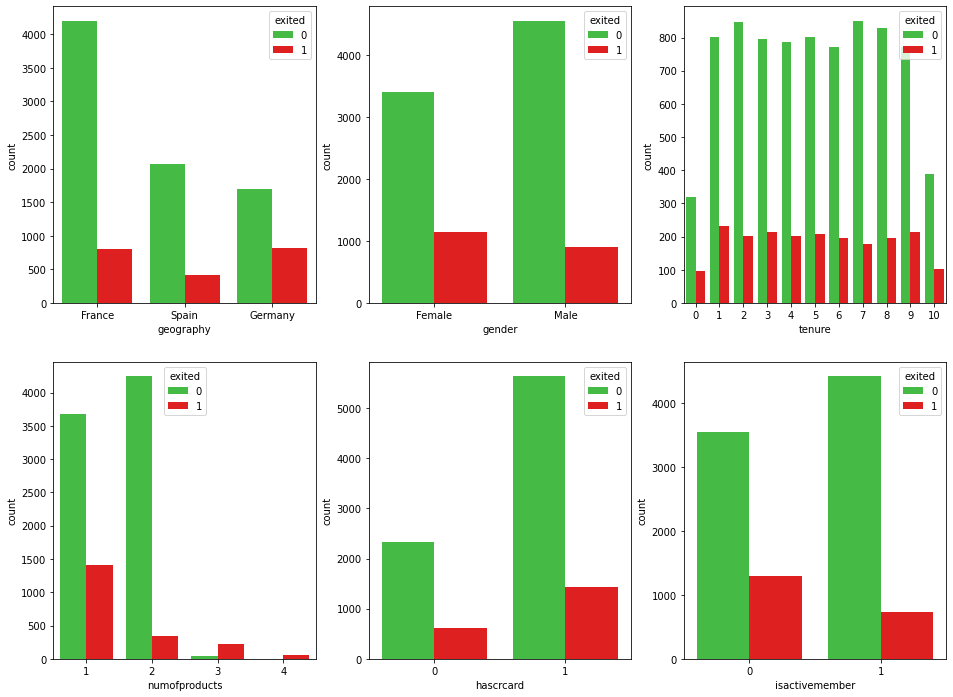

In [21]:
#Putting all the above results in a single visualization

cat_data=['geography', 'gender', 'tenure','numofproducts', 'hascrcard','isactivemember']
q=1
plt.figure(figsize=(16,12),facecolor='white')
# Plot a grid with count plots of all categorical variables
for i in cat_data:
    plt.subplot(2,3,q)
    ax=sns.countplot(data[i],hue=data.exited)
    plt.xlabel(i)
    q+=1

plt.savefig('../images/independentfeatures_distrib.png')
plt.show()

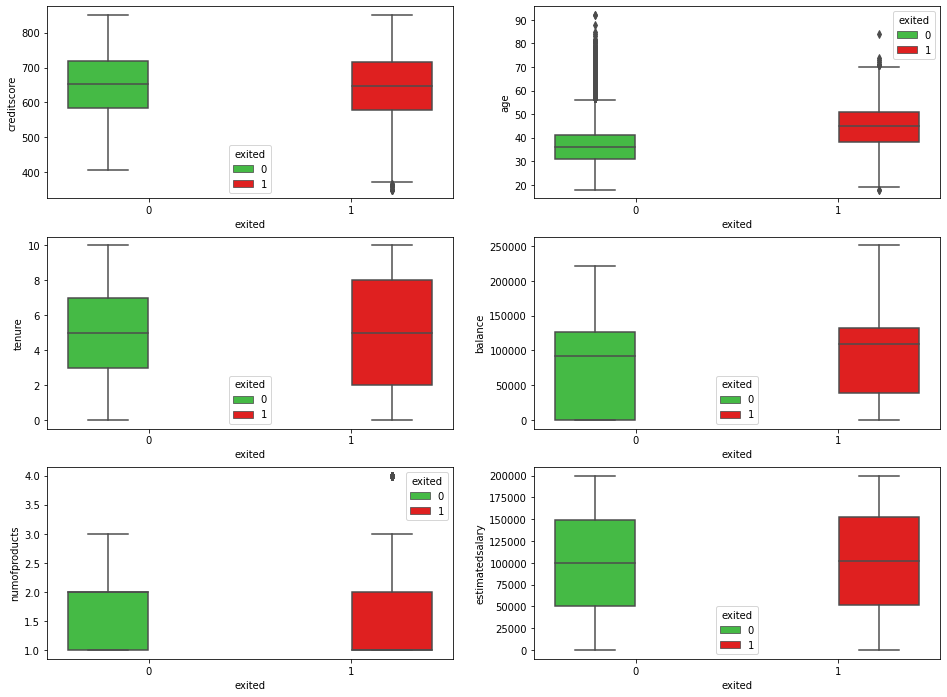

In [22]:
# Relations based on the continuous data attributes
fig, axarr = plt.subplots(3, 2,facecolor='white',figsize=(16,12))
sns.boxplot(y='creditscore',x = 'exited', hue = 'exited',data = data, ax=axarr[0][0])
sns.boxplot(y='age',x = 'exited', hue = 'exited',data = data , ax=axarr[0][1])
sns.boxplot(y='tenure',x = 'exited', hue = 'exited',data = data, ax=axarr[1][0])
sns.boxplot(y='balance',x = 'exited', hue = 'exited',data = data, ax=axarr[1][1])
sns.boxplot(y='numofproducts',x = 'exited', hue = 'exited',data = data, ax=axarr[2][0])
sns.boxplot(y='estimatedsalary',x = 'exited', hue = 'exited',data = data, ax=axarr[2][1])
plt.savefig('../images/boxplots.png')

In [23]:
# correlation of each variable
# data.corr()

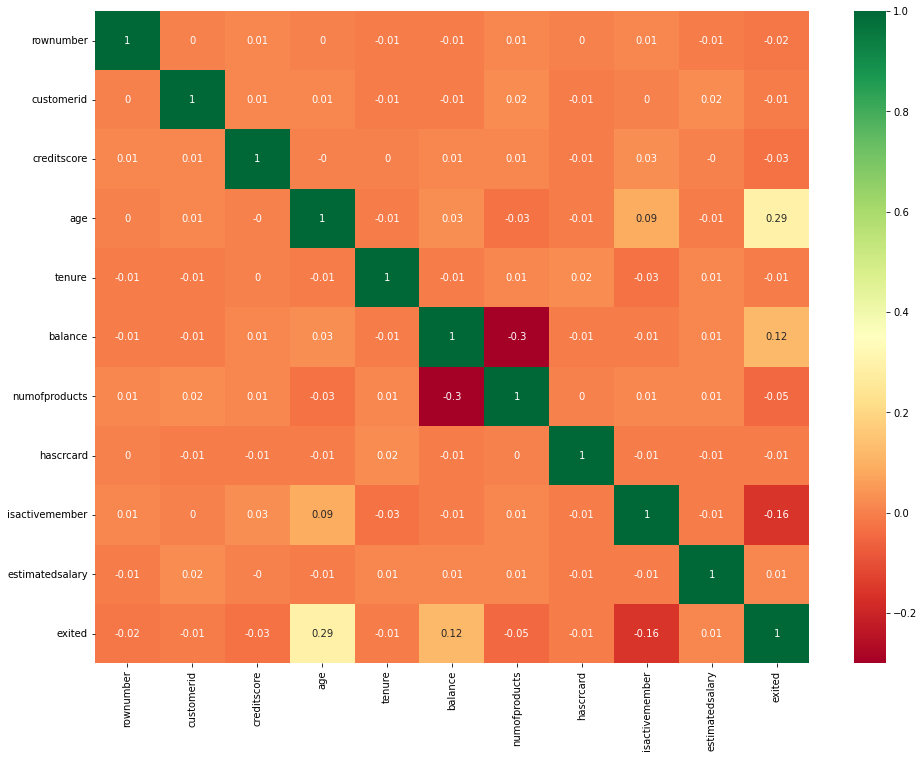

In [24]:
# Viewing correlations of each features in dataset 
datacorr = round(data.corr(),2)
corrmat = datacorr
top_corr_features = corrmat.index
plt.figure(figsize=(16,12),facecolor='white')

# Plotting heat map
plot = sns.heatmap(datacorr,annot=True,cmap="RdYlGn")
plt.savefig('../images/churn_correlation.png')

In [25]:
# Profile report of each variable
# pandas_profiling.ProfileReport(data)

#### **----------------------------------  5. Feature engineering  -----------------------------------**

In [26]:
# Dropping fields that wont benefit the model
data.drop(labels=['rownumber','customerid','surname'], axis=1, inplace=True)

In [27]:
# One Hot encoding for remaining categorical field 
data = pd.get_dummies(data, drop_first = False)
data.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_France,geography_Germany,geography_Spain,gender_Female,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


In [28]:
data.dtypes

creditscore            int64
age                    int64
tenure                 int64
balance              float64
numofproducts          int64
hascrcard              int64
isactivemember         int64
estimatedsalary      float64
exited                 int64
geography_France       uint8
geography_Germany      uint8
geography_Spain        uint8
gender_Female          uint8
gender_Male            uint8
dtype: object

In [29]:
scale_vars = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary' ]

# Robust scaler to address outliers 
transformer = RobustScaler().fit(data[scale_vars])
data[scale_vars] = transformer.transform(data[scale_vars])

# # Storing the columns and indexes in varaibles so the conactenation can work correctly
# cols = X.columns
# index = X.index

# # Robust scaler to address outliers 
# transformer = RobustScaler().fit(X)
# X = transformer.transform(X)

# # Outputting scaled features into new dataframe as before and concatenating the remaining categorical features to it
# X = pd.DataFrame(X, columns = cols, index = index)
# X = pd.concat([X,cat_data], axis = 1)


# Splitting dependent and independent features to apply scaling
X = data.drop(["exited"],axis=1)

# Dependent feature | Target variable 
y= data['exited']

In [30]:
# Viewing first 5 rows of data
X.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_France,geography_Germany,geography_Spain,gender_Female,gender_Male
0,-0.246269,0.416667,-0.75,-0.761480,0.0,1,1,0.011739,1,0,0,1,0
1,-0.328358,0.333333,-1.00,-0.104906,0.0,0,1,0.125512,0,0,1,1,0
2,-1.119403,0.416667,0.75,0.489346,2.0,1,0,0.139630,1,0,0,1,0
3,0.350746,0.166667,-1.00,-0.761480,1.0,0,0,-0.064717,1,0,0,1,0
4,1.477612,0.500000,-0.75,0.221806,0.0,1,1,-0.214561,0,0,1,1,0


In [31]:
# Viewing the shape of the data
print(X.shape, y.shape)

(10000, 13) (10000,)


In [32]:
# Using train test split to split train and test data | Stratifying so y_test can reflect y_train.Resulting in a more realistic simulation of how the model is going to perform on new data
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.20, random_state=23, shuffle=True, stratify=y)

# Viewing shape of train / test data
print(X_train.shape)
print(X_test.shape)

(8000, 13)
(2000, 13)


#### **----------------------------------  6. Modelling  -----------------------------------**

We are ready to build different models looking for the best fit. Predicting customer churn is a binary classification problem: Customers are either lost or retained in a given period of time.

For this aim, I'll test:

* Logistic regression classifier
* K-nearest Neighbors classifier
* Support Vector Classifier
* Decision Tree Classifier
* Random Forest Classifier

In [33]:
# Preparing algorithms in a list
random_state = 23
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(n_neighbors = 5),
    SVC(gamma='auto'),
    DecisionTreeClassifier(criterion = 'gini', max_depth = 3),
    RandomForestClassifier(max_features = 'sqrt', n_jobs = 1, verbose = 1)]

In [34]:
# Creating a df to show models and their accuracy 
log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns = log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    print("=" * 30)
    print(name)
    print('****  Results  ****')
    
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    print("\n")
    
    # Creating new df and appending results onto initial df 
    log_entry = pd.DataFrame([[name, acc * 100]], columns = log_cols)
    log = log.append(log_entry)
    
print("=" * 30)

LogisticRegression
****  Results  ****
Accuracy: 81.0500%


KNeighborsClassifier
****  Results  ****
Accuracy: 82.9500%


SVC
****  Results  ****
Accuracy: 86.5000%


DecisionTreeClassifier
****  Results  ****
Accuracy: 84.6000%




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RandomForestClassifier
****  Results  ****
Accuracy: 86.9000%




[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


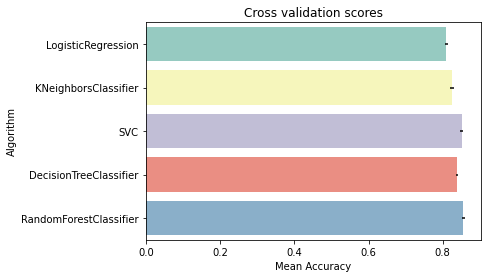

In [35]:
# Cross validate model with Kfold stratified cross validation
kfold = StratifiedKFold(n_splits=5)

# Modeling step Test differents algorithms 
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["LogisticRegression","KNeighborsClassifier","SVC","DecisionTreeClassifier","RandomForestClassifier"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

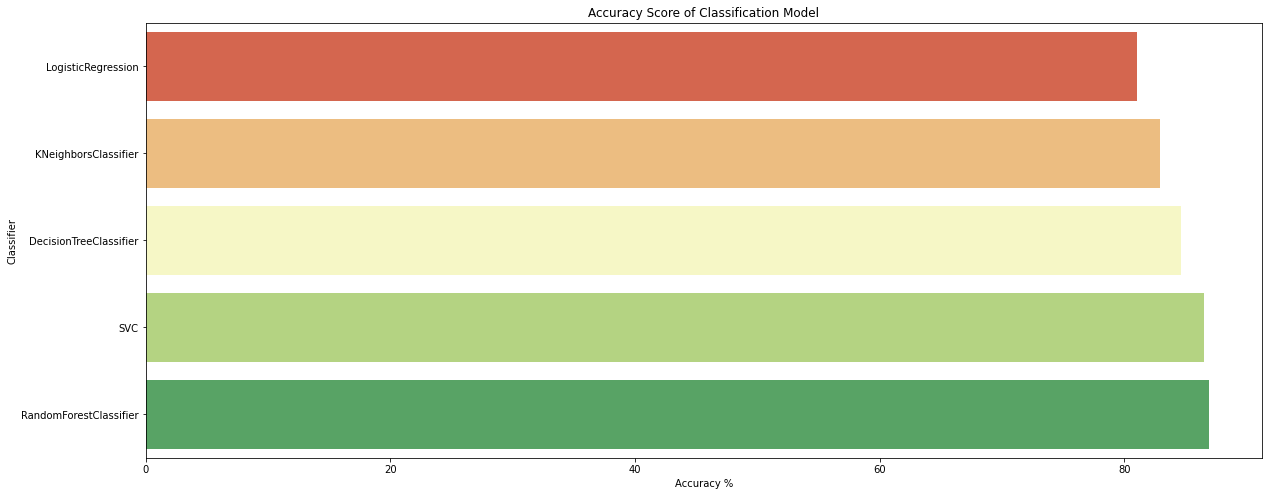

In [36]:
# Sorting model performance data
log = log.sort_values(by=['Accuracy'])

# Visualising accuracy models
plt.figure(figsize = (20,8),facecolor='white')
sns.set_color_codes("muted")
sns.barplot(x = 'Accuracy', y = 'Classifier', data = log,palette="RdYlGn")
plt.xlabel('Accuracy %')
plt.title('Accuracy Score of Classification Model')
plt.savefig('../images/Crossvalidation.png')
plt.show()

#### **----------------------------------  8. Evaluation -----------------------------------**

We will determine the parameters and values that we want to search in each of our models. Then, we will perform the GridSearchCV and set the best parameters obtained in our model.

In [37]:
def print_best_model(model):
    """
    Outputs the best parameteres, score and estimator for the model given.
    """
    print(f"The best parameters are: {model.best_params_}")
    print(f"The best model score is: {model.best_score_}")    
    print(f"The best estimator is: {model.best_estimator_}")

#### **Support Vector Classification**

In [38]:
# Using linspace to trial array of values in GridSearchCV parameters 
Cparams = np.linspace(105, 112, 7,dtype=int)
Gammaparams = np.linspace(0.02,0.025, 10,dtype=float)

# Defining parameters for GridSearchCV
params = {
    'C':       Cparams,
    'gamma': Gammaparams
}

# Initialising algorithm 
svc = SVC()

# Outputting best param with GridDearch
svc_best = GridSearchCV(svc, params, cv=4)

# Fitting best paramters to X and y
svc_best.fit(X_train,y_train)

GridSearchCV(cv=4, estimator=SVC(),
             param_grid={'C': array([105, 106, 107, 108, 109, 110, 112]),
                         'gamma': array([0.02      , 0.02055556, 0.02111111, 0.02166667, 0.02222222,
       0.02277778, 0.02333333, 0.02388889, 0.02444444, 0.025     ])})

In [39]:
# Calling function to output best parameters 
print_best_model(svc_best)

The best parameters are: {'C': 109, 'gamma': 0.025}
The best model score is: 0.8566250000000001
The best estimator is: SVC(C=109, gamma=0.025)


In [99]:
# Fitting best model
model1 = SVC(C=106, gamma=0.02388888888888889,probability=True)
model1.fit(X_train, y_train)

SVC(C=106, gamma=0.02388888888888889, probability=True)

In [100]:
# Predicting using X_test
svc_predict_train = model1.predict(X_train)

print("=========================================")
# Checking the accuracy score 
print(accuracy_score(y_train, svc_predict_train))
print("=========================================")

# Viewing classification report
print('Classification Report of Support Vector Classification: \n')
print(classification_report(y_train, svc_predict_train))


0.8595
Classification Report of Support Vector Classification: 

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      6370
           1       0.81      0.41      0.54      1630

    accuracy                           0.86      8000
   macro avg       0.84      0.69      0.73      8000
weighted avg       0.85      0.86      0.84      8000



In [101]:
# Getting accruacy of model orignally 
svc_initial = log.loc[log['Classifier'] == 'SVC', 'Accuracy'].iloc[0]/100

# Predicting using X_train
svc_predict_test = model1.predict(X_test)

# WORSE
worse = round((svc_initial - accuracy_score(y_test, svc_predict_test)), 5)

# BETTER
better = round((accuracy_score(y_test, svc_predict_test) - svc_initial ), 5)

print("=========================================")
# Checking the accuracy score 
print(accuracy_score(y_test, svc_predict_test))
print("=========================================")

if accuracy_score(y_test, svc_predict_test) > svc_initial:
    print("-----------------------------------------")
    print(f"{better}%", "improvement in the model accuracy.")
    print("-----------------------------------------")
elif svc_initial > accuracy_score(y_test, svc_predict_test):
    print("-----------------------------------------")
    print(f"{worse}%", "reduction in the model accuracy.")
    print("-----------------------------------------")
else:
    print("-----------------------------------------")
    print(" No change in the model accuracy.")
    print("-----------------------------------------")


# Viewing classification report
print('Classification Report of Support Vector Classification: \n')
print(classification_report(y_test, svc_predict_test))

0.8635
-----------------------------------------
0.0015% reduction in the model accuracy.
-----------------------------------------
Classification Report of Support Vector Classification: 

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1593
           1       0.84      0.41      0.55       407

    accuracy                           0.86      2000
   macro avg       0.85      0.69      0.73      2000
weighted avg       0.86      0.86      0.84      2000



           Non churn  Churn
Non churn       1561     32
Churn            241    166


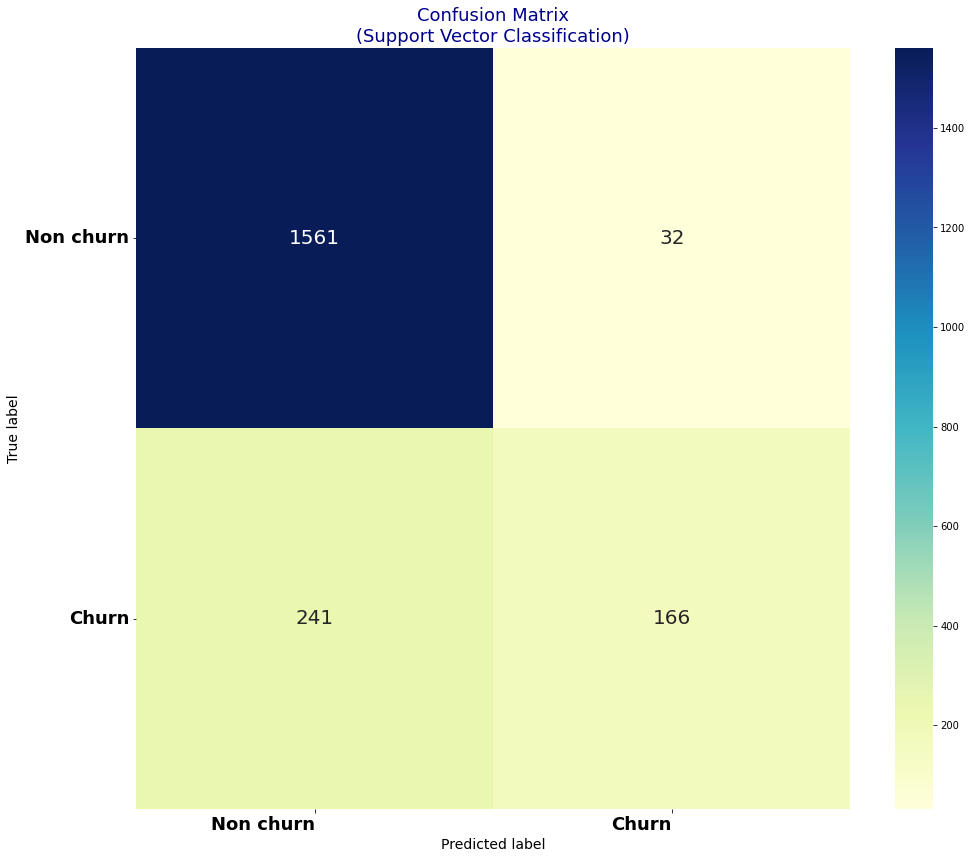

In [102]:
# Plotting confusion matrix
matrix = pd.DataFrame((metrics.confusion_matrix(y_test, svc_predict_test)), 
                      ('Non churn', 'Churn'), 
                      ('Non churn', 'Churn'))
print(matrix)

# Visualising confusion matrix
plt.figure(figsize = (16,14),facecolor='white')
heatmap = sns.heatmap(matrix, annot = True, annot_kws = {'size': 20}, fmt = 'd', cmap = 'YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = 18, weight='bold')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = 18, weight='bold')

plt.title('Confusion Matrix\n(Support Vector Classification)', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.savefig('../images/Confusionmatrixsvc.png')
plt.show()

#### **Random Forest Classifier**

In [103]:
# Using linspace to trial array of values in GridSearchCV parameters 
maxdepth = np.linspace(80, 110, 2,dtype=int)
maxfeatures = np.linspace(2,4, 2,dtype=int)
minsampleaf = np.linspace(2, 5, 2,dtype=int)
minsampsplit = np.linspace(6,12, 2,dtype=int)
nestimators = np.linspace(100,1000, 3,dtype=int)

# Defining parameters for GridSearchCV
params = {
    'bootstrap': [True],
    'max_depth': maxdepth,
    'max_features': maxfeatures,
    'min_samples_leaf': minsampleaf,
    'min_samples_split': minsampsplit,
    'n_estimators': nestimators
}

# Initialising algorithm 
rf = RandomForestClassifier()

# Outputting best param with GridDearch
rf_best = GridSearchCV(rf,params, cv = 3, n_jobs = 1, verbose = 1)

# Fitting best paramters to X and y
rf_best.fit(X,y)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


KeyboardInterrupt: 

In [ ]:
# Calling function to output best parameters 
print_best_model(rf_best)

The best parameters are: {'bootstrap': True, 'max_depth': 80, 'max_features': 4, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 550}
The best model score is: 0.8655993673752498
The best estimator is: RandomForestClassifier(max_depth=80, max_features=4, min_samples_leaf=2,
                       min_samples_split=6, n_estimators=550)


In [ ]:
# Fitting best model
model2 = RandomForestClassifier(max_depth=80, max_features=4, min_samples_leaf=2, min_samples_split=6)
model2.fit(X_train, y_train)

RandomForestClassifier(max_depth=80, max_features=4, min_samples_leaf=2,
                       min_samples_split=6)

In [ ]:
# Predicting using X_test
rf_predict_train = model2.predict(X_train)

print("=========================================")
# Checking the accuracy score 
print(accuracy_score(y_train, rf_predict_train))
print("=========================================")

# Viewing classification report
print('Classification Report of Support Vector Classification: \n')
print(classification_report(y_train, rf_predict_train))


0.946625
Classification Report of Support Vector Classification: 

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      6370
           1       0.97      0.76      0.85      1630

    accuracy                           0.95      8000
   macro avg       0.95      0.88      0.91      8000
weighted avg       0.95      0.95      0.94      8000



In [ ]:
# Getting accruacy of model orignally 
rf_initial = log.loc[log['Classifier'] == 'RandomForestClassifier', 'Accuracy'].iloc[0]/100

# Predicting using X_train
rf_predict_test = model2.predict(X_test)

# WORSE
worse = round((rf_initial - accuracy_score(y_test, rf_predict_test)), 5)

# BETTER
better = round((accuracy_score(y_test, rf_predict_test) - rf_initial ), 5)

print("=========================================")
# Checking the accuracy score 
print(accuracy_score(y_test, rf_predict_test))
print("=========================================")

if accuracy_score(y_test, rf_predict_test) > rf_initial:
    print("-----------------------------------------")
    print(f"{better}%", "improvement in the model accuracy.")
    print("-----------------------------------------")
elif rf_initial > accuracy_score(y_test, rf_predict_test):
    print("-----------------------------------------")
    print(f"{worse}%", "reduction in the model accuracy.")
    print("-----------------------------------------")
else:
    print("-----------------------------------------")
    print(" No change in the model accuracy.")
    print("-----------------------------------------")


# Viewing classification report
print('Classification Report of Support Vector Classification: \n')
print(classification_report(y_test, rf_predict_test))

0.869
-----------------------------------------
0.0005% reduction in the model accuracy.
-----------------------------------------
Classification Report of Support Vector Classification: 

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.79      0.48      0.60       407

    accuracy                           0.87      2000
   macro avg       0.84      0.72      0.76      2000
weighted avg       0.86      0.87      0.86      2000



In [ ]:
# Fitting best model
model2 = RandomForestClassifier(max_features = 'sqrt', n_jobs = 1, verbose = 1)
model2.fit(X_train, y_train)

rf_predict_test = model2.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
# Getting accruacy of model orignally 
rf_initial = log.loc[log['Classifier'] == 'RandomForestClassifier', 'Accuracy'].iloc[0]/100

# Predicting using X_train
rf_predict_test = model2.predict(X_test)

# WORSE
worse = round((rf_initial - accuracy_score(y_test, rf_predict_test)), 5)

# BETTER
better = round((accuracy_score(y_test, rf_predict_test) - rf_initial ), 5)

print("=========================================")
# Checking the accuracy score 
print(accuracy_score(y_test, rf_predict_test))
print("=========================================")

if accuracy_score(y_test, rf_predict_test) > rf_initial:
    print("-----------------------------------------")
    print(f"{better}%", "improvement in the model accuracy.")
    print("-----------------------------------------")
elif rf_initial > accuracy_score(y_test, rf_predict_test):
    print("-----------------------------------------")
    print(f"{worse}%", "reduction in the model accuracy.")
    print("-----------------------------------------")
else:
    print("-----------------------------------------")
    print(" No change in the model accuracy.")
    print("-----------------------------------------")


# Viewing classification report
print('Classification Report of Support Vector Classification: \n')
print(classification_report(y_test, rf_predict_test))

0.8705
-----------------------------------------
0.001% improvement in the model accuracy.
-----------------------------------------
Classification Report of Support Vector Classification: 

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.80      0.48      0.60       407

    accuracy                           0.87      2000
   macro avg       0.84      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
# Plotting confusion matrix
matrix = pd.DataFrame((metrics.confusion_matrix(y_test, rf_predict_test)), 
                      ('Non churn', 'Churn'), 
                      ('Non churn', 'Churn'))
print(matrix)

# Visualising confusion matrix
plt.figure(figsize = (16,12),facecolor='white')
heatmap = sns.heatmap(matrix, annot = True, annot_kws = {'size': 20}, fmt = 'd', cmap = 'YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = 18, weight='bold')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = 18, weight='bold')

plt.title('Confusion Matrix\n(Random Forest Classifier)', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.savefig('../images/Confusionmatrixrf.png')
plt.show()

           Non churn  Churn
Non churn       1544     49
Churn            210    197


I can investigate the false positive rates and true positive rates using ROC Curve and calculating the area under the curve that it is also a metric of the prediction power of our model (if the value is closer to 1 means that our model does a good job in differentiating a random sample into the two classes).
AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.

In [ ]:
# Error checking of MSE & RMSE 
mse = metrics.mean_squared_error(y_test,rf_predict_test)
print('Mean Squared Error : '+ str(mse))
rmse = math.sqrt(metrics.mean_squared_error(y_test, rf_predict_test))
print('Root Mean Squared Error : '+ str(rmse))

Mean Squared Error : 0.1295
Root Mean Squared Error : 0.35986108430893166


In [ ]:
# Function to return values for the ROC Curve
def get_scores(y, predicted, predicted_proba):
    """
    returns the roc and auc scores for the given predictions
    """
    auc_score = roc_auc_score(y, predicted)
    fpr_df, tpr_df, _ = roc_curve(y, predicted_proba) 
    return auc_score, fpr_df, tpr_df

In [ ]:
# Getting values for 1st and 2nd model 
auc_svc, fpr_svc, tpr_svc = get_scores(y, model1.predict(X), model1.predict_proba(X)[:,1])
auc_rf, fpr_rf, tpr_rf = get_scores(y, model2.predict(X), model2.predict_proba(X)[:,1])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [ ]:
# Plotting ROC Curve 
plt.figure(figsize = (12,6), linewidth= 1,facecolor='white')
plt.plot(fpr_svc, tpr_svc, label = f'SVC Score: {str(round(auc_svc, 3))}', color='#82E0AA')
plt.plot(fpr_rf, tpr_rf, label = f'Random Forest Score: {str(round(auc_rf, 3))}', color='#A569BD')
plt.plot([0,1], [0,1], '--', label = 'score 0.5', color='#34495E')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.savefig('../images/ROC_Curve.png')
plt.show()

In [ ]:
# Finding feature importances of the model 
rf1=RandomForestClassifier()
feature_imp = pd.Series(rf1.fit(X_train, y_train).feature_importances_,
                        index=X.columns).sort_values(ascending=False)

In [ ]:
feature_imp = feature_imp.to_frame()
feature_imp.reset_index(inplace=True)
feature_imp.rename(columns ={"index": "features", 0: "Importance"}, inplace=True)

In [ ]:
# printing feature importance dataframe
feature_imp

,features,Importance
0,age,0.239404
1,estimatedsalary,0.146800
2,creditscore,0.143692
3,balance,0.143316
4,numofproducts,0.121982
5,tenure,0.084927
6,isactivemember,0.041766
7,geography_Germany,0.020840
8,hascrcard,0.019253
9,geography_France,0.010676


In [ ]:
# Visualising feature importance 
plt.figure(figsize = (16,8),facecolor='white')
sns.barplot(x=feature_imp.Importance, y=feature_imp.features)
plt.xlabel('Score')
plt.ylabel('Features')
plt.title("Random Forest")
plt.savefig('../images/Feature_importance.png')
plt.close(2)
plt.show()

#### **----------------------------------  9. Exporting Model -----------------------------------**

In [ ]:
# dump model into pickle file
pickle.dump(model2, open('.././rf_churn_model.pkl', 'wb'))